In [1]:
import os
import numpy as np
from sklearn import preprocessing

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Flatten, Conv2D, BatchNormalization, Lambda, Conv3D
from keras.layers import MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D, Add
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers

Using TensorFlow backend.


# Modeling

### Load NumPy Arrays & convert labels

In [2]:
segs = 512

In [3]:
# Load compressed NumPy arrays
with np.load('orpheusC' + str(segs) + '.npz') as data:
    X_Train = data['X_Train']
    X_Val = data['X_Val']
    X_Test = data['X_Test']
    Y_Train = data['Y_Train']
    Y_Val  = data['Y_Val']
    Y_Test = data['Y_Test']

In [4]:
# Convert numerical labels to integers
le = preprocessing.LabelEncoder()
Y_Train = le.fit_transform(Y_Train)
Y_Val = le.fit_transform(Y_Val)
Y_Test =le.fit_transform(Y_Test)
le.classes_

array(['Blues', 'Classical', 'Country', 'Hip-Hop', 'Jazz', 'Metal', 'Pop',
       'Rock'], dtype='<U9')

In [5]:
# Confirm sample balance
import pandas as pd
Y_Traindf = pd.DataFrame(le.inverse_transform(Y_Train))
Y_Valdf = pd.DataFrame(le.inverse_transform(Y_Val))
Y_Testdf = pd.DataFrame(le.inverse_transform(Y_Test))
Y_Traindf[0].value_counts(),Y_Valdf[0].value_counts(),Y_Testdf[0].value_counts()

(Country      880
 Pop          880
 Jazz         880
 Blues        880
 Metal        880
 Classical    880
 Hip-Hop      880
 Rock         880
 Name: 0, dtype: int64,
 Metal        110
 Classical    110
 Pop          110
 Country      110
 Hip-Hop      110
 Jazz         110
 Rock         110
 Blues        110
 Name: 0, dtype: int64,
 Metal        110
 Classical    110
 Pop          110
 Country      110
 Hip-Hop      110
 Jazz         110
 Rock         110
 Blues        110
 Name: 0, dtype: int64)

### Build Model(s)

#### CNN (Timbre + Pitch)

In [6]:
inshape = (segs, 12, 2)

In [7]:
# set dropout rate
dr = 0.35

In [8]:
model = Sequential()

# 3x 2D Convolution layers
model.add(Conv2D(48, (5, 5), activation='relu', strides=(1, 1), input_shape=inshape))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(rate=dr))

model.add(Conv2D(64, (5, 5), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(rate=dr))

model.add(Conv2D(64, (5, 5), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), strides=(2,2)))
model.add(Dropout(rate=dr))

model.add(Flatten())
model.add(Dropout(rate=dr))

# Dense layer with ReLU activation
model.add(Dense(64, activation='relu'))

# Output layer
model.add(Dense(8, activation='softmax'))

### Compile Model

In [10]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Train Model

In [11]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, min_delta=0.01, patience=8)

In [12]:
# iterating 30 times on the data in batches of 32 samples then saving training history
hist = model.fit(X_Train, Y_Train, epochs=75, batch_size=64, validation_data=(X_Val, Y_Val), callbacks=[es])


Train on 7040 samples, validate on 880 samples
Epoch 1/75
7040/7040 [==============================] - 85s 12ms/step - loss: 2.3907 - accuracy: 0.2013 - val_loss: 1.7285 - val_accuracy: 0.2909
Epoch 2/75
7040/7040 [==============================] - 80s 11ms/step - loss: 1.5699 - accuracy: 0.3807 - val_loss: 1.4040 - val_accuracy: 0.4443
Epoch 3/75
7040/7040 [==============================] - 79s 11ms/step - loss: 1.3682 - accuracy: 0.4699 - val_loss: 1.3127 - val_accuracy: 0.4920
Epoch 4/75
7040/7040 [==============================] - 78s 11ms/step - loss: 1.2270 - accuracy: 0.5281 - val_loss: 1.2623 - val_accuracy: 0.5341
Epoch 5/75
7040/7040 [==============================] - 78s 11ms/step - loss: 1.1797 - accuracy: 0.5528 - val_loss: 1.1554 - val_accuracy: 0.5966
Epoch 6/75
7040/7040 [==============================] - 81s 12ms/step - loss: 1.0948 - accuracy: 0.5847 - val_loss: 1.1652 - val_accuracy: 0.5795
Epoch 7/75
7040/7040 [==============================] - 78s 11ms/step - loss

In [13]:
# Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 508, 8, 48)        2448      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 254, 4, 48)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 254, 4, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 254, 4, 64)        76864     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 127, 2, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 127, 2, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 127, 2, 64)       

In [14]:
model.save(os.getcwd() + '/models/mixed/cnn_' + str(segs) + '_' + str(round(model.evaluate(X_Test, Y_Test)[1], 3)) + '.h5')

880/880 [==============================] - 4s 4ms/step


# Model Evaluation

### Plotting training and validation loss

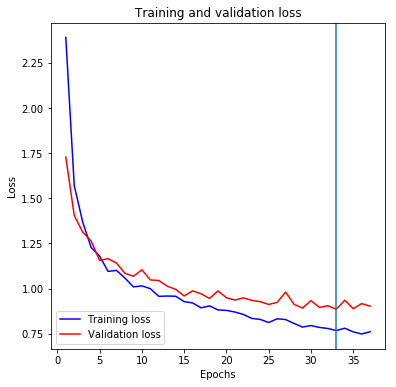

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.axvline(x = (np.argmin(val_loss)+1))
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plotting training and validation accuracy

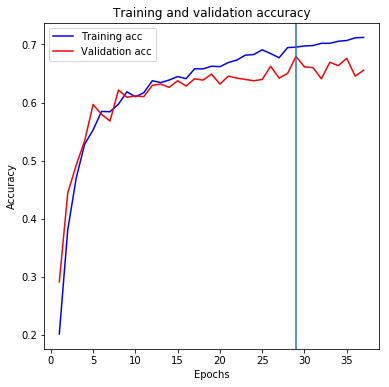

In [16]:
plt.figure(figsize=(6,6))
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.axvline(x = (np.argmax(val_acc)+1))
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
# Epoch with highest validation accucary
np.argmax(val_acc)+1, val_acc[np.argmax(val_acc)]

(29, 0.6795454621315002)

In [18]:
results = model.evaluate(X_Test, Y_Test)
print('Test loss:', results[0])
print('Test accuracy:', results[1])

880/880 [==============================] - 3s 4ms/step
Test loss: 0.8908621755513277
Test accuracy: 0.6784090995788574


### Accuracy per Genre

In [19]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_Test)
y_pred = np.argmax(y_pred, axis=1)
print(confusion_matrix(Y_Test, y_pred))

[[ 77   2   7   1   6   3   5   9]
 [  4 104   0   0   2   0   0   0]
 [ 18   0  67   0   2   1  15   7]
 [  0   1   0  93   5   0  11   0]
 [ 17  10   0   4  71   1   3   4]
 [  2   3   0   0   2  92   2   9]
 [  5   0   3  22   3   3  55  19]
 [ 16   1  11   2   5  31   6  38]]


Text(258.72, 0.5, 'Prediction')

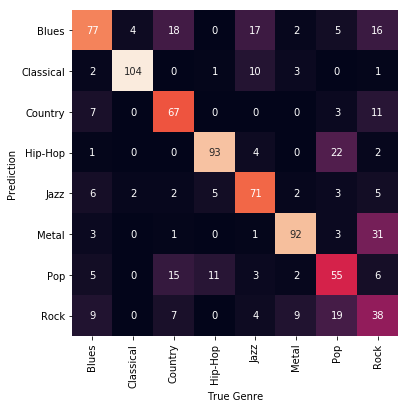

In [20]:
# Visualizing confusion matrix
import seaborn as sns

plt.figure(figsize=(12,6))
cm = confusion_matrix(Y_Test, y_pred)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=list(le.classes_),
            yticklabels=list(le.classes_))
plt.xlabel('True Genre')
plt.ylabel('Prediction')

In [21]:
from sklearn.metrics import classification_report

print(Y_Test.shape, y_pred.shape)
print(classification_report(Y_Test, y_pred, target_names=list(le.classes_)))

(880,) (880,)
              precision    recall  f1-score   support

       Blues       0.55      0.70      0.62       110
   Classical       0.86      0.95      0.90       110
     Country       0.76      0.61      0.68       110
     Hip-Hop       0.76      0.85      0.80       110
        Jazz       0.74      0.65      0.69       110
       Metal       0.70      0.84      0.76       110
         Pop       0.57      0.50      0.53       110
        Rock       0.44      0.35      0.39       110

    accuracy                           0.68       880
   macro avg       0.67      0.68      0.67       880
weighted avg       0.67      0.68      0.67       880



In [22]:
# Create pandas df from classification report
report = classification_report(Y_Test, y_pred, target_names=list(le.classes_), output_dict=True)
reportdf = pd.DataFrame(report)
reportdf.T

,precision,recall,f1-score,support
Blues,0.553957,0.700000,0.618474,110.000000
Classical,0.859504,0.945455,0.900433,110.000000
Country,0.761364,0.609091,0.676768,110.000000
Hip-Hop,0.762295,0.845455,0.801724,110.000000
Jazz,0.739583,0.645455,0.689320,110.000000
Metal,0.702290,0.836364,0.763485,110.000000
Pop,0.567010,0.500000,0.531401,110.000000
Rock,0.441860,0.345455,0.387755,110.000000
accuracy,0.678409,0.678409,0.678409,0.678409
macro avg,0.673483,0.678409,0.671170,880.000000


In [23]:
# Export to latex
reportdf.to_latex('Class_Report_Mixed.tex', float_format="%.3f")